# Notebook for moisture transport project 

**TO DO**

- create timeseries with anomalies for P, E and moisture transport (MFC)
- wavelet analysis on hourly data 
- decomposition of MFC in eddy and mean flow 
- decomposition in thermodynamic and dynamic component 


**Project ideas:**
- do the same for WRF data 
- do the same for extreme events on different time scales 
- do the same events for extreme events on different spatial scales 

## Climatological precipitation and evaporation ERA5 

In [1]:
import numpy as np 
import xarray as xr
import metpy 
from metpy import calc

In [2]:
f= 'cache/era5_monthlymean_clim_precip.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
f= 'cache/era5_monthlymean_clim_evapo.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]*-1000
f= 'cache/era5_monthlymean_clim_moistdiv.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture.vimd.values[0]

p_e = P - E 


In [92]:
## elevation for contour of TP 
## Import elevation file for 3000 m boundary 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values

## calculate vertically integrated moisture divergence from q and wind fields 

- get moisture divergent fields for every year!
- how to convert unit of specific humidity (kg/kg) to mm/day 

In [124]:
f = 'cache/era5_summerclim.nc'

mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
q = mfields.q[0]

# vertical sums (or integration)
u = np.nansum(u, axis = 0)
v = np.nansum(v, axis = 0)
q = np.nansum(q, axis = 0)

lats= mfields.latitude
lons = mfields.longitude

In [125]:
from metpy.units import units
# assign unit to grid spacing
R = 6371*1000
dx = 2*np.pi*R * (0.25/360)
dy = 2*np.pi*R *(0.25/360) * np.cos(np.mean(lats.values)) *( -1)
dx = dx * units.meters
dy = dy * units.meters
C= 1/(9.81*1000)

In [126]:
# calculate total moisture flux convergence, which is the first spatial derivative of humidity and the wind vectors
qu = q*u
qv = q*v
moistDIV = -C* calc.divergence(qu,qv, dx= dx, dy = dy)

moistDIV

Magnitude,[[-0.005865384446959442 -0.005834686845796397 -0.0064554762396646925 ... 0.014175192596531903 0.01740737712145478 0.022719022212225916] [-0.009536025896809021 -0.008713496568741617 -0.008888921097961288 ... 0.017750189912565863 0.021176089110750158 0.025587403896372304] [-0.013822961417780772 -0.013576840685421606 -0.0130921612324907 ... 0.018482532720695655 0.01955309357677624 0.021772583114541996] ... [-0.5927322027323569 -0.3637466706030412 -0.12786284366267667 ... 0.005880085106204017 -0.006228129561028972 -0.018012435653693787] [-0.8315721997217147 -0.5443188768509014 -0.26357543240131937 ... -0.001818793418123492 -0.0038023272992897127 -0.01881171292817423] [-1.021025386447894 -0.8913431074920835 -0.6890212056660656 ... -0.008453129801666742 0.01292874443824985 0.013011586672385752]]
Units,1/meter


## decomposition in thermodynamic and dynamic component

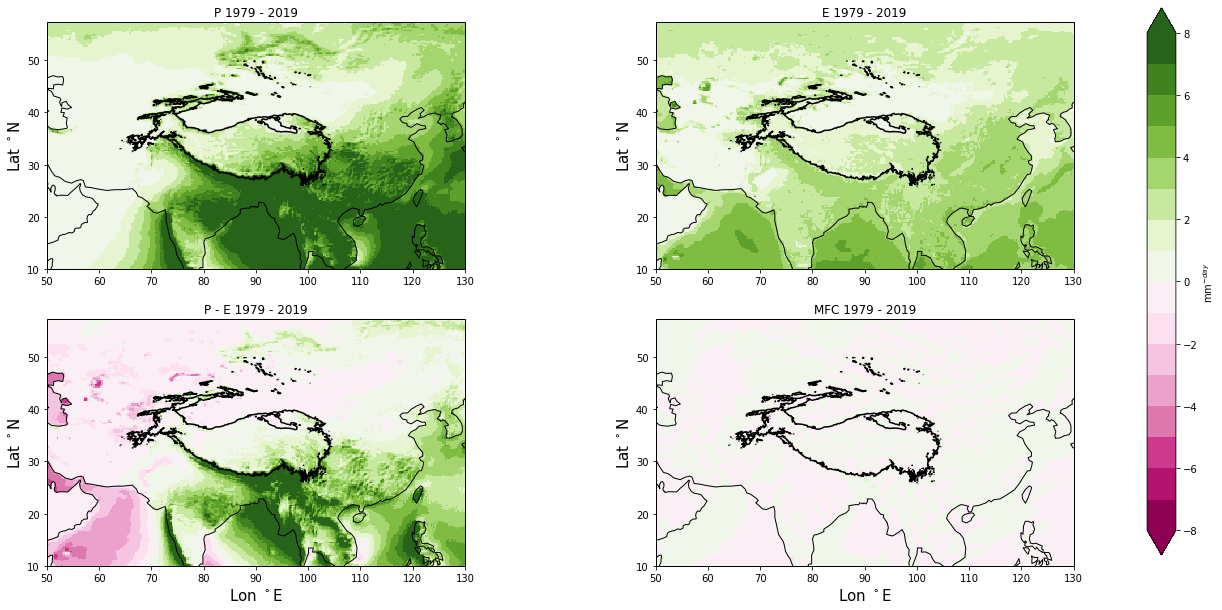

In [127]:
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors


## track density plot 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

fig =plt.figure(figsize=(20,10))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

# customizing of colorbar 
cmap=plt.cm.PiYG
#cmap=plt.cm.coolwarm
r = np.arange(-8,9)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values


# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title('P 1979 - 2019')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=15)



# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title('E 1979 - 2019')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=15)




# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title('P - E 1979 - 2019')
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=15)



# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -moistDIV, norm = norm, cmap = cmap  )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('MFC 1979 - 2019')
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=15)


cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm$^{-day}$')


plt.savefig('plots/moisture_budget_era5.png')
plt.show()

## Time series of P, E and moisture transport 

Is summer precipitation variability dominated by moisture transport (remote controls) or by evaporation anomalies (local controls)? 

## Decomposition in mean flow and eddies 

In [145]:
f= 'cache/precip_timeseries.nc'
precip = xr.open_dataset(f)
P = precip.tp.values*1000
f= 'cache/evapo_timeseries.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values*-1000
f= 'cache/moistdiv_timeseries.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture.vimd.values

In [143]:
x = np.arange(1979,2019)


In [144]:
P.shape

(205, 1, 1)

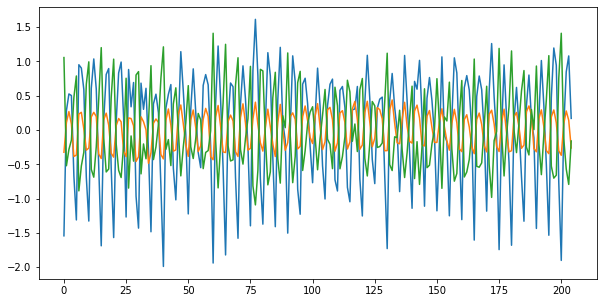

In [141]:
p_clim = np.mean(P[:,0,0])
e_clim = np.mean(E[:,0,0])
m_clim = np.mean(moistdiv[:,0,0])


plt.figure(figsize= (10,5))


plt.plot(P[:,0,0] - p_clim)
plt.plot(E[:,0,0]- e_clim)
plt.plot(moistdiv[:,0,0] - m_clim)